# NoteBook to Make Descriptives

This notebook is for looking at final population zonal stats data

In [1]:
from rasterstats import zonal_stats
import rasterio
import geopandas as gpd
import operator
import numpy as np
import pandas as pd
import matplotlib 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from functools import reduce
import squarify

# Functions

In [ ]:
def city_search(gpd_df, city_list, country):
    """ function will print out city name and population for a subset of a gridded dataset gpd
    requires data frame, list of cities, and country of interest
    """
    gpd_df_sub = gpd_df[gpd_df['country'] == country]
    
    for index, row in gpd_df_sub.iterrows():
        for city in city_list:
            if row['city'] == city:
                print(city)
                print(round(row['PopTot']))

In [ ]:
def str_id(gpd_df):
    """
    Function makes a new col with a unique lat-lon string to identify each osm point & drops duplicates
    Function also makes
    """

    
    print(gpd_df.shape)
    
    lat_string = gpd_df.lat.astype(str)
    lon_string = gpd_df.lon.astype(str)
    gpd_df['str_id'] = lat_string.astype(str)+lon_string.astype(str)
    
    print(gpd_df.shape)


In [ ]:
def dup_drop(gpd_in, col, keep_dup):
    """ 
    function drops duplicates based on a column from a pd data frame
    requires pd df out string, pd df, col name, and which dup to keep
    returns new gpd_df
    """
    
    gpd_out = gpd.GeoDataFrame()
    
    print(gpd_in.shape)
    
    gpd_out = gpd_in.drop_duplicates(col, keep = keep_dup)
    
    print(gpd_out.shape)

    return gpd_out

    

In [ ]:
def df_merge(df_left, df_right):
    
    pd_out = pd.DataFrame()
    pd_out = pd.merge(df_left[['str_id', 'PopTot']], df_right[['str_id', 'PopTot']], on='str_id', how = 'inner')
    
    left_pop = pd_out.PopTot_x.astype(str)
    right_pop = pd_out.PopTot_y.astype(str)
    pd_out['pop_id'] = left_pop.astype(str)+right_pop.astype(str)

    return pd_out

In [ ]:
def p_X_gt_x(data, X=None):
    n_data = len(data)
    if X is None:
        X = data.unique()
    return X, pd.Series([sum(data>=x)/n_data for x in X ])

def p_X_lt_x(data, X=None):
    n_data = len(data)
    if X is None:
        X = data.unique()
    return X, pd.Series([sum(data<=x)/n_data for x in X ])

# Data

In [2]:
# File paths

data_raw = '/Users/cascade/Github/NTL/data/raw/'
data_temp = '/Users/cascade/Github/NTL/temp_data/'
data_interim = '/Users/cascade/Github/NTL/data/interim/'
ms_data = '/Users/cascade/Github/NTL/temp_data/MS_Data/'
erl_data = '/Users/cascade/Github/NTL/temp_data/ERL_data/'
downloads = '/Users/cascade/Downloads/'

In [3]:
# Data

# GHS2000 = gpd.read_file(erl_data+'GHS_POP_GPW42000_final20190122.shp')
# GHS2015 = gpd.read_file(erl_data+'GHS_POP_GPW42015_final20190122.shp')
# WP2000 = gpd.read_file(erl_data+'AFR_PPP_2000_adj_v2_final20190122.shp')
# WP2015 = gpd.read_file(erl_data+'AFR_PPP_2015_adj_v2_final20190122.shp')
# LS2015 = gpd.read_file(erl_data+'WPE_1KM_2016_final20190122.shp')
# WPE2016 = gpd.read_file(erl_data+'LS15_final20190122.shp')

# Data with Rain Zones & Regions added, & FIDs Dropped (2019-02-13)

GHS2000 = gpd.read_file(erl_data+'GHS_POP_GPW42000_20190213.shp')
GHS2015 = gpd.read_file(erl_data+'GHS_POP_GPW42015_20190213.shp')
WP2000 = gpd.read_file(erl_data+'AFR_PPP_2000_adj_v2_20190213.shp')
WP2015 = gpd.read_file(erl_data+'AFR_PPP_2015_adj_v2_20190213.shp')
LS2015 = gpd.read_file(erl_data+'WPE_1KM_2016_20190213.shp')
WPE2016 = gpd.read_file(erl_data+'LS15_20190213.shp')


In [87]:
# Identify dataset

GHS2000['data'] = 'GHS-Pop 2000'
GHS2015['data'] = 'GHS-Pop 2015'
WP2000['data'] = 'WorldPop 2000'
WP2015['data'] = 'WorldPop 2015'
LS2015['data'] = 'LandScan 2015'
WPE2016['data'] = 'WPE 2016'

In [5]:
# List of datasets
datasets_in = [GHS2000, GHS2015, WP2000, WP2015, LS2015, WPE2016]

### Calc Some Stats for Tables

In [ ]:
country = 'Nigeria'

test = GHS2000[GHS2000['country'] == country]
#test = test[test.PopTot <5*10**6]
print(test.PopTot.count())
print(test.PopTot.median())
print(test.PopTot.mean())

test = GHS2015[GHS2015['country'] == country]
#test = test[test.PopTot <5*10**6]
print(test.PopTot.count())
print(test.PopTot.median())
print(test.PopTot.mean())

In [ ]:
country = 'Nigeria'

test = GHS2000[GHS2000['country'] == country]
#test = test[test.PopTot <5*10**6]
print(test.PopTot.sum())

test = GHS2015[GHS2015['country'] == country]
#test = test[test.PopTot <5*10**6]
print(test.PopTot.sum())


In [ ]:
test

In [ ]:
test = GHS2015[GHS2015.PopTot > 5*10**6]
test = test[test.osm_type == 'city']
test.tail(50)

In [ ]:
out = dup_drop(test, 'FID', 'first')
out

### Chunk by Rain Zone

For GHS 2000 and 2015 ... replace variables and run through twice.

In [ ]:
GHS2015.rain_zone.unique()

In [ ]:
# Chunk by Rain Zone 

GHS2000_arid = GHS2000[GHS2000['rain_zone'] == 'Arid']
GHS2000_semi = GHS2000[GHS2000['rain_zone'] == 'Semi-arid']
GHS2000_sub = GHS2000[GHS2000['rain_zone'] == 'Sub-humid']
GHS2000_humid = GHS2000[GHS2000['rain_zone'] == 'Humid']

# print(len(GHS2000_arid))
# GHS2000_arid = GHS2000_arid[GHS2000_arid['country'] != 'Egypt']
# print(len(GHS2000_arid))
# GHS2000_semi = GHS2000_semi[GHS2000_semi['country'] != 'Egypt']
# GHS2000_sub = GHS2000_sub[GHS2000_sub['country'] != 'Egypt']
# GHS2000_humid = GHS2000_humid[GHS2000_humid['country'] != 'Egypt']

In [ ]:
# GHS 2000 Arid Chunks 
GHS2000_arid_50k = GHS2000_arid.loc[(GHS2000_arid['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2000_arid_50k)

GHS2000_arid_100k = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 5*10**4) & (GHS2000_arid['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2000_arid_100k)

GHS2000_arid_250k = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 10**5) & (GHS2000_arid['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2000_arid_250k)

GHS2000_arid_500k = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 2.5*10**5) & (GHS2000_arid['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2000_arid_500k)

GHS2000_arid_1m = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 5*10**5) & (GHS2000_arid['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2000_arid_1m)

GHS2000_arid_5m = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 10**6) & (GHS2000_arid['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2000_arid_5m)

GHS2000_arid_5mplus = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2000_arid_5mplus)

In [ ]:
# GHS Semi Arid Chunks 
GHS2000_semi_50k = GHS2000_semi.loc[(GHS2000_semi['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2000_semi_50k)

GHS2000_semi_100k = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 5*10**4) & (GHS2000_semi['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2000_semi_100k)

GHS2000_semi_250k = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 10**5) & (GHS2000_semi['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2000_semi_250k)

GHS2000_semi_500k = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 2.5*10**5) & (GHS2000_semi['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2000_semi_500k)

GHS2000_semi_1m = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 5*10**5) & (GHS2000_semi['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2000_semi_1m)

GHS2000_semi_5m = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 10**6) & (GHS2000_semi['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2000_semi_5m)

GHS2000_semi_5mplus = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2000_semi_5mplus)

In [ ]:
# GHS Sub Humid Chunks 
GHS2000_sub_50k = GHS2000_sub.loc[(GHS2000_sub['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2000_sub_50k)

GHS2000_sub_100k = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 5*10**4) & (GHS2000_sub['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2000_sub_100k)

GHS2000_sub_250k = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 10**5) & (GHS2000_sub['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2000_sub_250k)

GHS2000_sub_500k = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 2.5*10**5) & (GHS2000_sub['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2000_sub_500k)

GHS2000_sub_1m = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 5*10**5) & (GHS2000_sub['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2000_sub_1m)

GHS2000_sub_5m = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 10**6) & (GHS2000_sub['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2000_sub_5m)

GHS2000_sub_5mplus = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2000_sub_5mplus)

In [ ]:
# GHS Humid Chunks 
GHS2000_humid_50k = GHS2000_humid.loc[(GHS2000_humid['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2000_humid_50k)

GHS2000_humid_100k = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 5*10**4) & (GHS2000_humid['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2000_humid_100k)

GHS2000_humid_250k = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 10**5) & (GHS2000_humid['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2000_humid_250k)

GHS2000_humid_500k = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 2.5*10**5) & (GHS2000_humid['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2000_humid_500k)

GHS2000_humid_1m = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 5*10**5) & (GHS2000_humid['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2000_humid_1m)

GHS2000_humid_5m = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 10**6) & (GHS2000_humid['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2000_humid_5m)

GHS2000_humid_5mplus = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2000_humid_5mplus)

In [ ]:
# GHS 2000
GHS2000_arid_bar = {'<50K':GHS2000_arid_50k, '50-100K': GHS2000_arid_100k, '100-150K':GHS2000_arid_250k,
    '250-500K' : GHS2000_arid_500k, '500K-1M' : GHS2000_arid_1m, '1-5M' : GHS2000_arid_5m, '>5M' : GHS2000_arid_5mplus
             }

GHS2000_semi_bar = {u'Label0':GHS2000_semi_50k, u'Label1': GHS2000_semi_100k, u'Label2':GHS2000_semi_250k,
    u'Label3' : GHS2000_semi_500k, u'Label4' : GHS2000_semi_1m, u'Label5' : GHS2000_semi_5m, u'Label6' : GHS2000_semi_5mplus
    }

GHS2000_sub_bar = {u'Label0':GHS2000_sub_50k, u'Label1': GHS2000_sub_100k, u'Label2':GHS2000_sub_250k,
    u'Label3' : GHS2000_sub_500k, u'Label4' : GHS2000_sub_1m, u'Label5' : GHS2000_sub_5m, u'Label6' : GHS2000_sub_5mplus
    }

GHS2000_humid_bar = {u'Label0':GHS2000_humid_50k, u'Label1': GHS2000_humid_100k, u'Label2':GHS2000_humid_250k,
    u'Label3' : GHS2000_humid_500k, u'Label4' : GHS2000_humid_1m, u'Label5' : GHS2000_humid_5m, u'Label6' : GHS2000_humid_5mplus
   }

In [ ]:
# GHS 2015
GHS2015_arid_bar = {'<50K':GHS2015_arid_50k, '50-100K': GHS2015_arid_100k, '100-150K':GHS2015_arid_250k,
    '250-500K' : GHS2015_arid_500k, '500K-1M' : GHS2015_arid_1m, '1-5M' : GHS2015_arid_5m, '>5M' : GHS2015_arid_5mplus
             }

GHS2015_semi_bar = {u'Label0':GHS2015_semi_50k, u'Label1': GHS2015_semi_100k, u'Label2':GHS2015_semi_250k,
    u'Label3' : GHS2015_semi_500k, u'Label4' : GHS2015_semi_1m, u'Label5' : GHS2015_semi_5m, u'Label6' : GHS2015_semi_5mplus
    }

GHS2015_sub_bar = {u'Label0':GHS2015_sub_50k, u'Label1': GHS2015_sub_100k, u'Label2':GHS2015_sub_250k,
    u'Label3' : GHS2015_sub_500k, u'Label4' : GHS2015_sub_1m, u'Label5' : GHS2015_sub_5m, u'Label6' : GHS2015_sub_5mplus
    }

GHS2015_humid_bar = {u'Label0':GHS2015_humid_50k, u'Label1': GHS2015_humid_100k, u'Label2':GHS2015_humid_250k,
    u'Label3' : GHS2015_humid_500k, u'Label4' : GHS2015_humid_1m, u'Label5' : GHS2015_humid_5m, u'Label6' : GHS2015_humid_5mplus
   }

### Rain Zone Pct Change

In [ ]:
arid_2000 = [GHS2000_arid_50k, GHS2000_arid_100k, GHS2000_arid_250k, GHS2000_arid_500k, GHS2000_arid_1m,
            GHS2000_arid_5m, GHS2000_arid_5mplus]

arid_2000_pct = np.round(arid_2000 / GHS2000.PopTot.sum() * 100, 1)

In [ ]:
semi_2000 = [GHS2000_semi_50k, GHS2000_semi_100k, GHS2000_semi_250k, GHS2000_semi_500k, GHS2000_semi_1m,
            GHS2000_semi_5m, GHS2000_semi_5mplus]

semi_2000_pct = np.round(semi_2000 / GHS2000.PopTot.sum() * 100, 1)
semi_2000_pct 

In [ ]:
sub_2000 = [GHS2000_sub_50k, GHS2000_sub_100k, GHS2000_sub_250k, GHS2000_sub_500k, GHS2000_sub_1m,
            GHS2000_sub_5m, GHS2000_sub_5mplus]

sub_2000_pct = np.round(sub_2000 / GHS2000.PopTot.sum() * 100, 1)
sub_2000_pct 

In [ ]:
humid_2000 = [GHS2000_humid_50k, GHS2000_humid_100k, GHS2000_humid_250k, GHS2000_humid_500k, GHS2000_humid_1m,
            GHS2000_humid_5m, GHS2000_humid_5mplus]

humid_2000_pct = np.round(humid_2000 / GHS2000.PopTot.sum() * 100, 1)
humid_2000_pct 

In [ ]:
arid_2015 = [GHS2015_arid_50k, GHS2015_arid_100k, GHS2015_arid_250k, GHS2015_arid_500k, GHS2015_arid_1m,
            GHS2015_arid_5m, GHS2015_arid_5mplus]

arid_2015_pct = np.round(arid_2015 / GHS2015.PopTot.sum() * 100, 1)
arid_2015_pct 

In [ ]:
semi_2015 = [GHS2015_semi_50k, GHS2015_semi_100k, GHS2015_semi_250k, GHS2015_semi_500k, GHS2015_semi_1m,
            GHS2015_semi_5m, GHS2015_semi_5mplus]

semi_2015_pct = np.round(semi_2015 / GHS2015.PopTot.sum() * 100, 1)
semi_2015_pct 

In [ ]:
sub_2015 = [GHS2015_sub_50k, GHS2015_sub_100k, GHS2015_sub_250k, GHS2015_sub_500k, GHS2015_sub_1m,
            GHS2015_sub_5m, GHS2015_sub_5mplus]

sub_2015_pct = np.round(sub_2015 / GHS2015.PopTot.sum() * 100, 1)
sub_2015_pct 

In [ ]:
humid_2015 = [GHS2015_humid_50k, GHS2015_humid_100k, GHS2015_humid_250k, GHS2015_humid_500k, GHS2015_humid_1m,
            GHS2015_humid_5m, GHS2015_humid_5mplus]

humid_2015_pct = np.round(humid_2015 / GHS2015.PopTot.sum() * 100, 1)
humid_2015_pct 

### Pct Change by Rainfall Zone

In [ ]:
# [a_i - b_i for a_i, b_i in zip(a, b)]

arid_delt = [(((a - b)/b)*100) for a, b in zip(arid_2015, arid_2000)]
semi_delt = [(((a - b)/b)*100) for a, b in zip(semi_2015, semi_2000)]
sub_delt = [(((a - b)/b)*100) for a, b in zip(sub_2015, sub_2000)]
humid_delt = [(((a - b)/b)*100) for a, b in zip(humid_2015[0:6], humid_2000[0:6])]


print(len(humid_delt))
humid_delt.append(0)
print(len(humid_delt))

In [ ]:
# Make some plots

# make plot
sns.set(font_scale=1.5)

#a = [0-.66,1-.66,2-.64,3-.66,4-.66,5-.66,6-.66]
a = [0-.44,1-.44,2-.44,3-.44,4-.44,5-.44,6-.44]
b = [0-.22,1-.22,2-.22,3-.22,4-.22,5-.22,6-.22]
c = [0,1,2,3,4,5,6]
d = [0+.22,1+.22,2+.22,3+.22,4+.22,5+.22,6+.22]
#d = [0+.44,1+.44,2+.44,3+.44,4+.44,5+.44,6+.44]

# Ticks
ticks_bar = ['<50K', '50-100K', '100-150K','250-500K', '500K-1M', '1-5M' , '>5M']


fig, ax = plt.subplots(nrows=1, ncols=1)

#2000
plt.bar(a, arid_delt, width=0.2, align='center', alpha  = 1, color = 'Blue')
plt.bar(b, semi_delt, width=0.2, align='center', alpha  = 1, color = 'Purple')
plt.bar(c, sub_delt, width=0.2, align='center', alpha  = 1, color = 'Red')
plt.bar(d, humid_delt, width=0.2, align='center', alpha = 1, color = 'Green')

bar_leg = ['Arid', 'Semi-arid', 'Sub-humid', 'Humid']

plt.legend(bar_leg,loc=2)

plt.xticks(range(len(ticks_bar)), ticks_bar)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 9)
#plt.gca().set_yscale('log')
plt.xlabel('Urban Settlement Size')
plt.ylabel('Pct. Change')
plt.title('Percent Change in GHS-Pop 2000 - 2015 by Rainfall Zone')
#ax.set_facecolor('White')
fig.savefig('/Users/cascade/Desktop/'+'PopRainGHS2000-15_bar.png', dpi=700, transparent=False)



# Total Change by Rain Zone

In [ ]:
totdelt_arid = [(a - b) for a, b in zip(arid_2015, arid_2000)]
totdelt_semi = [(a - b) for a, b in zip(semi_2015, semi_2000)]
totdelt_sub = [(a - b) for a, b in zip(sub_2015, sub_2000)]
totdelt_humid = [(a - b) for a, b in zip(humid_2015, humid_2000)]
totdelt_all = [(a - b) for a, b in zip(GHS2015_chunks, GHS2000_chunks)]

In [ ]:
np.sum(arid_2015)

In [ ]:
test = GHS2015[GHS2015['rain_zone'] == 'Arid']
print(test.PopTot.sum())
test = test[test['country'] != 'Egypt']
print(test.PopTot.sum())

In [ ]:
# Make some plots

# make plot
sns.set(font_scale=1.5)

#a = [0-.66,1-.66,2-.64,3-.66,4-.66,5-.66,6-.66]
a = [0-.44,1-.44,2-.44,3-.44,4-.44,5-.44,6-.44]
b = [0-.22,1-.22,2-.22,3-.22,4-.22,5-.22,6-.22]
c = [0,1,2,3,4,5,6]
d = [0+.22,1+.22,2+.22,3+.22,4+.22,5+.22,6+.22]
#d = [0+.44,1+.44,2+.44,3+.44,4+.44,5+.44,6+.44]

# Ticks
ticks_bar = ['<50K', '50-100K', '100-150K','250-500K', '500K-1M', '1-5M' , '>5M']


fig, ax = plt.subplots(nrows=1, ncols=1)

#2000
plt.bar(a, [x / 10**6 for x in totdelt_arid], width=0.2, align='center', alpha  = 1, color = 'Blue')
plt.bar(b, [x / 10**6 for x in totdelt_semi], width=0.2, align='center', alpha  = 1, color = 'Purple')
plt.bar(c, [x / 10**6 for x in totdelt_sub], width=0.2, align='center', alpha  = 1, color = 'Red')
plt.bar(d, [x / 10**6 for x in totdelt_humid], width=0.2, align='center', alpha = 1, color = 'Green')
#plt.bar(f, [x / 10**6 for x in totdelt_all], width=0.15, align='center', alpha = 0.7, color = 'Black')


bar_leg = ['Arid', 'Semi-arid', 'Sub-humid', 'Humid', 'Africa']

plt.legend(bar_leg,loc=2)

plt.xticks(range(len(ticks_bar)), ticks_bar)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 9)
#plt.gca().set_yscale('log')
plt.xlabel('Urban Settlement Size')
plt.ylabel('Population (Millions)')
plt.title('Total Change in GHS-Pop 2000 - 2015 by Rainfall Zone')
#ax.set_facecolor('White')
fig.savefig('/Users/cascade/Desktop/'+'PopRainGHS2000-15_barTOT.png', dpi=700, transparent=False)

In [ ]:
# Break up by Rain Zone 2000

GHS2000_rain = GHS2000[GHS2000['rain_zone'] != '0']
GHS2000_rain = GHS2000_rain[GHS2000_rain['rain_zone'] != 'NoClass']
GHS2000_rain =  GHS2000_rain[GHS2000_rain['rain_zone'] != 'NA']
GHS2000_rain['raincat'] = GHS2000_rain.rain_zone + ' 2000'

# Break up by Rain Zone 2015 & add unique col 
GHS2015_rain = GHS2015[GHS2015['rain_zone'] != '0']
GHS2015_rain = GHS2015_rain[GHS2015_rain['rain_zone'] != 'NoClass']
GHS2015_rain =  GHS2015_rain[GHS2015_rain['rain_zone'] != 'NA']
GHS2015_rain['raincat'] = GHS2015_rain.rain_zone + ' 2015'

# Join the two
datasets_rain = [GHS2000_rain, GHS2015_rain]
datasets_rain_concat = pd.concat(datasets_rain, ignore_index=True)


In [ ]:
sns.set(font_scale=1)

plot_order = ['Arid 2000', 'Arid 2015', 'Semi-arid 2000', 'Semi-arid 2015',
              'Sub-humid 2000', 'Sub-humid 2015', 'Humid 2000', 'Humid 2015']

pal = ['Blue', 'Blue', 'Purple', 'Purple', 'Red', 'Red', 'Green', 'Green']

ax = sns.boxplot(x = 'PopTot', y = 'raincat', data = datasets_rain_concat, order = plot_order, palette = pal, 
                 sym = '')


# Add transparency to colors
for patch in ax.artists:
 r, g, b, a = patch.get_facecolor()
 patch.set_facecolor((r, g, b, .7))


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4.5, 3)
plt.gca().set_xscale('log')
plt.xlabel('Urban Settlement Size')
plt.ylabel('')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('Distribution by Moisture Zone 2000 & 2015', x = 0.25)
ax.set_facecolor('White')
#fig.savefig('/Users/cascade/Desktop/'+'PopRainGHS2000-15_box.png', dpi=700, transparent=False,
#           bbox_inches='tight')

In [ ]:
round(datasets_rain_concat.groupby(['raincat']).PopTot.std())

### Chunk by Dataset 

In [75]:
# WP 2015 Chunks
WP2015_50k = WP2015.loc[(WP2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(WP2015_50k)

WP2015_100k = WP2015.loc[(WP2015['PopTot'] > 5*10**4) & (WP2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(WP2015_100k)

WP2015_250k = WP2015.loc[(WP2015['PopTot'] > 10**5) & (WP2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(WP2015_250k)

WP2015_500k = WP2015.loc[(WP2015['PopTot'] > 2.5*10**5) & (WP2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(WP2015_500k)

WP2015_1m = WP2015.loc[(WP2015['PopTot'] > 5*10**5) & (WP2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(WP2015_1m)

WP2015_5m = WP2015.loc[(WP2015['PopTot'] > 10**6) & (WP2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(WP2015_5m)

WP2015_5mplus = WP2015.loc[(WP2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(WP2015_5mplus)

32201707.237106323
25449623.476852417
46911857.434947185
34533143.84853259
44698553.905130506
112615952.7138133
168529234.33390665


In [76]:
# LS 2015 Chunks 

LS2015_50k = LS2015.loc[(LS2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(LS2015_50k)

LS2015_100k = LS2015.loc[(LS2015['PopTot'] > 5*10**4) & (LS2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(LS2015_100k)

LS2015_250k = LS2015.loc[(LS2015['PopTot'] > 10**5) & (LS2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(LS2015_250k)

LS2015_500k = LS2015.loc[(LS2015['PopTot'] > 2.5*10**5) & (LS2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(LS2015_500k)

LS2015_1m = LS2015.loc[(LS2015['PopTot'] > 5*10**5) & (LS2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(LS2015_1m)

LS2015_5m = LS2015.loc[(LS2015['PopTot'] > 10**6) & (LS2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(LS2015_5m)

LS2015_5mplus = LS2015.loc[(LS2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(LS2015_5mplus)

49941576.0
38320063.0
73111799.0
53319903.0
51959247.0
125045247.0
181894436.0


In [77]:
#GHS 2015 Chunks

GHS2015_50k = GHS2015.loc[(GHS2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2015_50k)

GHS2015_100k = GHS2015.loc[(GHS2015['PopTot'] > 5*10**4) & (GHS2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2015_100k)

GHS2015_250k = GHS2015.loc[(GHS2015['PopTot'] > 10**5) & (GHS2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2015_250k)

GHS2015_500k = GHS2015.loc[(GHS2015['PopTot'] > 2.5*10**5) & (GHS2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2015_500k)

GHS2015_1m = GHS2015.loc[(GHS2015['PopTot'] > 5*10**5) & (GHS2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2015_1m)

GHS2015_5m = GHS2015.loc[(GHS2015['PopTot'] > 10**6) & (GHS2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2015_5m)

GHS2015_5mplus = GHS2015.loc[(GHS2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2015_5mplus)

57728877.42721522
42367750.20154512
65942109.05190321
42797144.48549347
43083124.61172706
117149248.11534087
131892407.58110312


In [78]:
# WPE 2016 Chunks
WPE2016_50k = WPE2016.loc[(WPE2016['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(WPE2016_50k)

WPE2016_100k = WPE2016.loc[(WPE2016['PopTot'] > 5*10**4) & (WPE2016['PopTot'] <= 10**5), 'PopTot'].sum()
print(WPE2016_100k)

WPE2016_250k = WPE2016.loc[(WPE2016['PopTot'] > 10**5) & (WPE2016['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(WPE2016_250k)

WPE2016_500k = WPE2016.loc[(WPE2016['PopTot'] > 2.5*10**5) & (WPE2016['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(WPE2016_500k)

WPE2016_1m = WPE2016.loc[(WPE2016['PopTot'] > 5*10**5) & (WPE2016['PopTot'] <= 10**6), 'PopTot'].sum()
print(WPE2016_1m)

WPE2016_5m = WPE2016.loc[(WPE2016['PopTot'] > 10**6) & (WPE2016['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(WPE2016_5m)

WPE2016_5mplus = WPE2016.loc[(WPE2016['PopTot'] > 5*10**6), 'PopTot'].sum()
print(WPE2016_5mplus)

47427429.0
28027611.0
50234162.0
35043497.0
39009926.0
126125882.0
173905597.0


In [79]:
# WP 2000 Chunks
WP2000_50k = WP2000.loc[(WP2000['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(WP2000_50k)

WP2000_100k = WP2000.loc[(WP2000['PopTot'] > 5*10**4) & (WP2000['PopTot'] <= 10**5), 'PopTot'].sum()
print(WP2000_100k)

WP2000_250k = WP2000.loc[(WP2000['PopTot'] > 10**5) & (WP2000['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(WP2000_250k)

WP2000_500k = WP2000.loc[(WP2000['PopTot'] > 2.5*10**5) & (WP2000['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(WP2000_500k)

WP2000_1m = WP2000.loc[(WP2000['PopTot'] > 5*10**5) & (WP2000['PopTot'] <= 10**6), 'PopTot'].sum()
print(WP2000_1m)

WP2000_5m = WP2000.loc[(WP2000['PopTot'] > 10**6) & (WP2000['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(WP2000_5m)

WP2000_5mplus = WP2000.loc[(WP2000['PopTot'] > 5*10**6), 'PopTot'].sum()
print(WP2000_5mplus)

28176791.003387928
20788879.657652378
31652150.280063786
27971259.82409185
34732227.645263076
87861582.9244433
54542867.037235975


In [80]:
# GHS 2000 Chunks
GHS2000_50k = GHS2000.loc[(GHS2000['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2000_50k)

GHS2000_100k = GHS2000.loc[(GHS2000['PopTot'] > 5*10**4) & (GHS2000['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2000_100k)

GHS2000_250k = GHS2000.loc[(GHS2000['PopTot'] > 10**5) & (GHS2000['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2000_250k)

GHS2000_500k = GHS2000.loc[(GHS2000['PopTot'] > 2.5*10**5) & (GHS2000['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2000_500k)

GHS2000_1m = GHS2000.loc[(GHS2000['PopTot'] > 5*10**5) & (GHS2000['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2000_1m)

GHS2000_5m = GHS2000.loc[(GHS2000['PopTot'] > 10**6) & (GHS2000['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2000_5m)

GHS2000_5mplus = GHS2000.loc[(GHS2000['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2000_5mplus)

55311697.50463867
33880336.81124878
45543428.39474487
29859523.565063477
25418817.078857422
75382972.25366211
55015416.7527771


In [81]:
# Chunks

WP2000_chunks = [WP2000_50k, WP2000_100k, WP2000_250k, WP2000_500k, WP2000_1m, WP2000_5m, WP2000_5mplus]
WP2015_chunks = [WP2015_50k, WP2015_100k, WP2015_250k, WP2015_500k, WP2015_1m, WP2015_5m, WP2015_5mplus]

GHS2000_chunks = [GHS2000_50k, GHS2000_100k, GHS2000_250k, GHS2000_500k, GHS2000_1m, GHS2000_5m, GHS2000_5mplus]
GHS2015_chunks = [GHS2015_50k, GHS2015_100k, GHS2015_250k, GHS2015_500k, GHS2015_1m, GHS2015_5m, GHS2015_5mplus]

LS2015_chunks = [LS2015_50k, LS2015_100k, LS2015_250k, LS2015_500k, LS2015_1m, LS2015_5m, LS2015_5mplus]

WPE2016_chunks = [WPE2016_50k, WPE2016_100k, WPE2016_250k, WPE2016_500k, WPE2016_1m, WPE2016_5m, WPE2016_5mplus]


In [82]:
#datasets_in = [GHS2000, GHS2015, WP2000, WP2015, LS2015, WPE2016]

data_chunks = [GHS2000_chunks, GHS2015_chunks, WP2000_chunks, WP2015_chunks, LS2015_chunks, WPE2016_chunks] 

In [83]:
# Percentages

GHS2000_chunks_pct = np.around(GHS2000_chunks / GHS2000.PopTot.sum() * 100, 1)
GHS2015_chunks_pct = np.around(GHS2015_chunks / GHS2015.PopTot.sum() * 100, 1)

WP2000_chunks_pct = np.around(WP2000_chunks / WP2000.PopTot.sum() * 100, 1)
WP2015_chunks_pct = np.around(WP2015_chunks / WP2015.PopTot.sum() * 100, 1)

LS2015_chunks_pct = np.around(LS2015_chunks / LS2015.PopTot.sum() * 100, 1)
WPE2016_chunks_pct = np.around(WPE2016_chunks / WPE2016.PopTot.sum() * 100, 1)

# Plots

### Bar plots

In [ ]:
# Total Change by Rain Zone

sns.set(font_scale=3)
x = [0,1,2,3,4,5,6]
y = [0-.22,1-.22,2-.22,3-.22,4-.22,5-.2,6-.22]
z = [0-.44,1-.44,2-.44,3-.44,4-.44,5-.44,6-.44]
a = [0+.22,1+.22,2+.22,3+.22,4+.22,5+.2,6+.22]

# Ticks
ticks_bar = ['<50K', '50-100K', '100-150K','250-500K', '500K-1M', '1-5M' , '>5M']


fig, ax = plt.subplots(nrows=1, ncols=1)

#2015
plt.bar(x, GHS2015_arid_bar.values(), width=0.2, align='center', alpha  = 0.3, color = 'Blue')
plt.bar(y, GHS2015_semi_bar.values(), width=0.2, align='center', alpha  = 0.3, color = 'Purple')
plt.bar(z, GHS2015_sub_bar.values(), width=0.2, align='center', alpha  = 0.3, color = 'Red')
plt.bar(a, GHS2015_humid_bar.values(), width=0.2, align='center', alpha = 0.3, color = 'Green')

#2000
plt.bar(x, GHS2000_arid_bar.values(), width=0.05, align='center', alpha  = 1, color = 'Blue', edgecolor = 'Black')
plt.bar(y, GHS2000_semi_bar.values(), width=0.05, align='center', alpha  = 1, color = 'Purple', edgecolor = 'Black')
plt.bar(z, GHS2000_sub_bar.values(), width=0.05, align='center', alpha  = 1, color = 'Red', edgecolor = 'Black')
plt.bar(a, GHS2000_humid_bar.values(), width=0.05, align='center', alpha = 1, color = 'Green', edgecolor = 'Black')

# bar_leg = ['WorldPop 2000 Arid', 'WorldPop 2000 Semi-arid', 'WorldPop 2000 Sub-humid', 'WorldPop 2000 Humid',
#           'WorldPop 2015 Arid', 'WorldPop 2015 Semi-arid', 'WorldPop 2015 Sub-humid', 'WorldPop 2015 Humid']

bar_leg = ['Arid', 'Semi']

plt.legend(bar_leg,loc=2)

plt.xticks(range(len(ticks_bar)), ticks_bar)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 15)
plt.gca().set_yscale('log')
plt.xlabel('Population')
plt.ylabel('')
plt.title('Total Urban Population by Settlement Size for Africa')
ax.set_facecolor('White')
# fig.savefig('/Users/cascade/Desktop/'+'PopAll_bar.png', dpi=700, transparent=False)



In [ ]:
# Pct Change by Rain Zone

# make plot
sns.set(font_scale=3)
x = [0,1,2,3,4,5,6]
y = [0-.22,1-.22,2-.22,3-.22,4-.22,5-.2,6-.22]
z = [0-.44,1-.44,2-.44,3-.44,4-.44,5-.44,6-.44]
a = [0+.22,1+.22,2+.22,3+.22,4+.22,5+.2,6+.22]

# Ticks
ticks_bar = ['<50K', '50-100K', '100-150K','250-500K', '500K-1M', '1-5M' , '>5M']


fig, ax = plt.subplots(nrows=1, ncols=1)

#2000
plt.bar(x, arid_2000_pct, width=0.2, align='center', alpha  = 0.3, color = 'Blue')
plt.bar(y, semi_2000_pct, width=0.2, align='center', alpha  = 0.3, color = 'Purple')
plt.bar(z, sub_2000_pct, width=0.2, align='center', alpha  = 0.3, color = 'Red')
plt.bar(a, humid_2000_pct, width=0.2, align='center', alpha = 0.3, color = 'Green')

#2000
plt.bar(x, arid_2015_pct, width=0.05, align='center', alpha  = 1, color = 'Blue', edgecolor = 'Black')
plt.bar(y, semi_2015_pct, width=0.05, align='center', alpha  = 1, color = 'Purple', edgecolor = 'Black')
plt.bar(z, sub_2015_pct, width=0.05, align='center', alpha  = 1, color = 'Red', edgecolor = 'Black')
plt.bar(a, humid_2015_pct, width=0.05, align='center', alpha = 1, color = 'Green', edgecolor = 'Black')

# bar_leg = ['WorldPop 2000 Arid', 'WorldPop 2000 Semi-arid', 'WorldPop 2000 Sub-humid', 'WorldPop 2000 Humid',
#           'WorldPop 2015 Arid', 'WorldPop 2015 Semi-arid', 'WorldPop 2015 Sub-humid', 'WorldPop 2015 Humid']

bar_leg = ['Arid', 'Semi']

plt.legend(bar_leg,loc=2)


plt.xticks(range(len(ticks_bar)), ticks_bar)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 15)
#plt.gca().set_yscale('log')
plt.xlabel('Population')
plt.ylabel('')
plt.title('Total Urban Population by Settlement Size for Africa')
ax.set_facecolor('White')
# fig.savefig('/Users/cascade/Desktop/'+'PopAll_bar.png', dpi=700, transparent=False)

In [ ]:
# Bar plot by Dataset 

import matplotlib.pyplot as plt

dictionary = plt.figure()

# Tick Lables
ticks_bar = ['<50K', '50-100K', '100-150K','250-500K', '500K-1M', '1-5M' , '>5M']

# Data
WP2015_bar = [WP2015_50k, WP2015_100k, WP2015_250k,
              WP2015_500k, WP2015_1m, WP2015_5m, WP2015_5mplus]

LS2015_bar = [LS2015_50k, LS2015_100k, LS2015_250k, LS2015_500k, 
              LS2015_1m, LS2015_5m, LS2015_5mplus]

GHS2015_bar = [GHS2015_50k,  GHS2015_100k, GHS2015_250k, GHS2015_500k, 
               GHS2015_1m, GHS2015_5m, GHS2015_5mplus]

WPE2016_bar = [WPE2016_50k, WPE2016_100k, WPE2016_250k,
               WPE2016_500k, WPE2016_1m, WPE2016_5m, WPE2016_5mplus]

# make plot
sns.set(font_scale=3)
fig, ax = plt.subplots(nrows=1, ncols=1)


a = [0-.4,1-.4,2-.4,3-.4,4-.4,5-.4,6-.4]
b = [0-.2,1-.2,2-.2,3-.2,4-.2,5-.2,6-.2]
c = [0,1,2,3,4,5,6]
d = [0+.2,1+.2,2+.2,3+.2,4+.2,5+.2,6+.2]


# [x / myInt for x in myList]
plt.bar(a, [x / 10**6 for x in WP2015_bar], width=0.2, align='center', alpha  = 0.7, color = 'Blue')
plt.bar(b, [x / 10**6 for x in LS2015_bar], width=0.2, align='center', alpha  = 0.7, color = 'Green')
plt.bar(c, [x / 10**6 for x in GHS2015_bar], width=0.2, align='center', alpha  = 0.7, color = 'Orange')
plt.bar(d, [x / 10**6 for x in WPE2016_bar], width=0.2, align='center', alpha = 0.7, color = 'Purple')

bar_leg = ['WorldPop 2015', 'LandScan 2015', 'GHS-Pop 2015', 'WPE 2016']
plt.legend(bar_leg,loc=2)



#plt.bar(range(len(D)), D.values(), align='center')

plt.xticks(range(len(ticks_bar)), ticks_bar, size = 28)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 15)
#plt.gca().set_yscale('log')
plt.xlabel('Settlement Size', size = 32)
plt.ylabel('Population (millions)', size = 32)
plt.title('Total Urban Population by Settlement Size for Africa')
ax.set_facecolor('White')
fig.savefig('/Users/cascade/Desktop/'+'PopAll_bar.png', dpi=700, transparent=False)


# ax.bar(x-0.2, y,width=0.2,color='b',align='center')
# ax.bar(x, z,width=0.2,color='g',align='center')
# ax.bar(x+0.2, k,width=0.2,color='r',align='center')

In [ ]:
GHS2000_chunks_pct = np.around(GHS2000_chunks / GHS2000.PopTot.sum() * 100, 1)
GHS2015_chunks_pct = np.around(GHS2015_chunks / GHS2015.PopTot.sum() * 100, 1)

WP2000_chunks_pct = np.around(WP2000_chunks / WP2000.PopTot.sum() * 100, 1)
WP2015_chunks_pct = np.around(WP2015_chunks / WP2015.PopTot.sum() * 100, 1)

LS2015_chunks_pct = np.around(LS2015_chunks / LS2015.PopTot.sum() * 100, 1)
WPE2016_chunks_pct = np.around(WPE2016_chunks / WPE2016.PopTot.sum() * 100, 1)

In [ ]:
# group by settlement size 
group0 = [WP2015_chunks_pct[0], LS2015_chunks_pct[0], GHS2015_chunks_pct[0], WPE2016_chunks_pct[0]]
group1 = [WP2015_chunks_pct[1], LS2015_chunks_pct[1], GHS2015_chunks_pct[1], WPE2016_chunks_pct[1]]
group2 = [WP2015_chunks_pct[2], LS2015_chunks_pct[2], GHS2015_chunks_pct[2], WPE2016_chunks_pct[2]]
group3 = [WP2015_chunks_pct[3], LS2015_chunks_pct[3], GHS2015_chunks_pct[3], WPE2016_chunks_pct[3]]
group4 = [WP2015_chunks_pct[4], LS2015_chunks_pct[4], GHS2015_chunks_pct[4], WPE2016_chunks_pct[4]]
group5 = [WP2015_chunks_pct[5], LS2015_chunks_pct[5], GHS2015_chunks_pct[5], WPE2016_chunks_pct[5]]
group6 = [WP2015_chunks_pct[6], LS2015_chunks_pct[6], GHS2015_chunks_pct[6], WPE2016_chunks_pct[6]]

In [ ]:
labels = ['WP 2015', 'LS 2015', 'GHS 2015', 'WPE 2016']

plt.bar(labels, group0)
plt.bar(labels, group1, bottom = group0)
plt.bar(labels, group2, bottom = [i+j for i,j in zip(group0, group1)])
plt.bar(labels, group3, bottom = [i+j+k for i,j,k in zip(group0, group1, group2)])
plt.bar(labels, group4, bottom = [i+j+k+l for i,j,k,l in zip(group0, group1, group2, group3)])
plt.bar(labels, group5, bottom = [i+j+k+l+m for i,j,k,l,m in zip(group0, group1, group2, group3, group4)])
plt.bar(labels, group6, bottom = [i+j+k+l+m+n for i,j,k,l,m,n in zip(group0, group1, group2, group3, group4, group5)])

### Square Plot

http://gvallver.perso.univ-pau.fr/?p=700

In [96]:
print(np.around(LS2015_chunks))
print(LS2015_chunks_pct)

[4.99415760e+07 3.83200630e+07 7.31117990e+07 5.33199030e+07
 5.19592470e+07 1.25045247e+08 1.81894436e+08]
[ 8.7  6.7 12.7  9.3  9.1 21.8 31.7]


In [99]:
# Make Data 

data = np.around(WP2015_chunks)
pct = WP2015_chunks_pct
chunks = ['<50K:', '50-100K: ', '100-150K: ','250-500K: ', '500K-1M: ', '1-5M: ', '>5M: ']

labels = [chunks[0]+'\n'+str(pct[0])+'%',
         chunks[1]+'\n'+str(pct[1])+'%',
         chunks[2]+'\n'+str(pct[2])+'%',
         chunks[3]+'\n'+str(pct[3])+'%',
         chunks[4]+'\n'+str(pct[4])+'%',
         chunks[5]+'\n'+str(pct[5])+'%',
         chunks[6]+'\n'+str(pct[6])+'%'
         ]


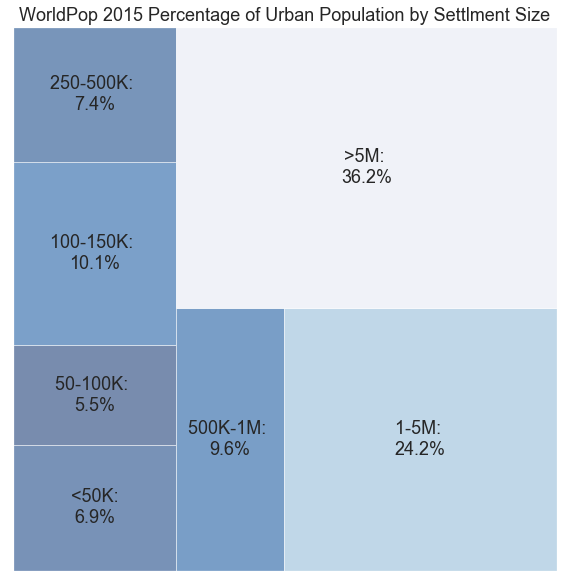

In [100]:
# set size
sns.set(font_scale=1.5)

# Set Colors
norm = matplotlib.colors.Normalize(vmin=min(data), vmax=max(data))
colors = [matplotlib.cm.Blues_r(norm(value)) for value in data]

# Create Plot
fig = plt.figure(figsize=(12, 10))
fig.suptitle("", fontsize=20)
ax = fig.add_subplot(111, aspect='equal')
ax1 = squarify.plot(data, color = colors, label=labels, ax=ax, alpha = 0.5)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('WorldPop 2015 Percentage of Urban Population by Settlment Size')

# color bar
bar_number = data/(10**6)

# create dummy invisible image with a color map
# img = plt.imshow([bar_number], cmap='Blues_r')
# img.set_visible(False)
# fig.colorbar(img, orientation="vertical", shrink=.96)
# fig.text(.76, .9, "Population in Millions", fontsize=14)

fig.savefig('/Users/cascade/Desktop/'+'WP2015_SquarePlot.png', dpi=700)


### Bar Plots

In [ ]:
# Data for Rain Zone Swarm Plot GHS 2015

# Break up by Rain Zone 2000

GHS2000_rain = GHS2000[GHS2000['rain_zone'] != '0']
GHS2000_rain = GHS2000_rain[GHS2000_rain['rain_zone'] != 'NoClass']
GHS2000_rain =  GHS2000_rain[GHS2000_rain['rain_zone'] != 'NA']
GHS2000_rain['raincat'] = GHS2000_rain.rain_zone + ' 2000'
GHS2000_rain['dataset'] = 'GHS2000'

# Break up by Rain Zone 2015 & add unique col 
GHS2015_rain = GHS2015[GHS2015['rain_zone'] != '0']
GHS2015_rain = GHS2015_rain[GHS2015_rain['rain_zone'] != 'NoClass']
GHS2015_rain =  GHS2015_rain[GHS2015_rain['rain_zone'] != 'NA']
GHS2015_rain['raincat'] = GHS2015_rain.rain_zone + ' 2015'
GHS2015_rain['dataset'] = 'GHS2015'


# Join the two
datasets_rain = [GHS2000_rain, GHS2015_rain]
datasets_rain_concat = pd.concat(datasets_rain, ignore_index=True)

In [ ]:
test = GHS2000_rain
c = test.raincat
log = np.log(test.PopTot)

In [ ]:
# make data with concat

test1 = datasets_rain_concat
c1 = test1.raincat
log1 = np.log(test1.PopTot)
group = datasets_rain_concat.dataset
country = datasets_rain_concat.country
region = datasets_rain_concat.region

d = {'cat': c1, 'log1': log1, 'group': group, 'country': country, 'region' : region}
df = pd.DataFrame(data=d)

df.head()

In [ ]:
# make data by country

df1 = GHS2000.loc[GHS2000['country'].isin(['Senegal', 'Zambia','Nigeria','Kenya', 'Ghana', 'Mali', 'Ethiopia'])]

df1['group'] = 'GHS2000'
df1.head()

df2 = GHS2015.loc[GHS2015['country'].isin(['Senegal', 'Zambia','Nigeria','Kenya', 'Ghana', 'Mali', 'Ethiopia'])]
df2['group'] = 'GHS2015'
 
df_list = [df1, df2]

df = pd.concat(df_list, ignore_index=True)

In [ ]:
plot_order = ['Arid 2000', 'Arid 2015', 'Semi-arid 2000', 'Semi-arid 2015',
              'Sub-humid 2000', 'Sub-humid 2015', 'Humid 2000', 'Humid 2015']

sns.set(font_scale=1.4)
fig = plt.figure(figsize=(7, 7))

ax = sns.boxplot(x = 'PopTot', y = 'country', hue = 'group', data = df, orient = 'h', dodge = True,
                showfliers=False)
#order = plot_order
ax.set_facecolor('White')
plt.legend(loc=4)
#ax.get_legend().remove()

plt.gca().set_xscale('log')

## Swarm Plots

In [89]:
# All data

d = [WP2015, LS2015, GHS2015, WPE2016]
df = pd.concat(d, ignore_index=True)

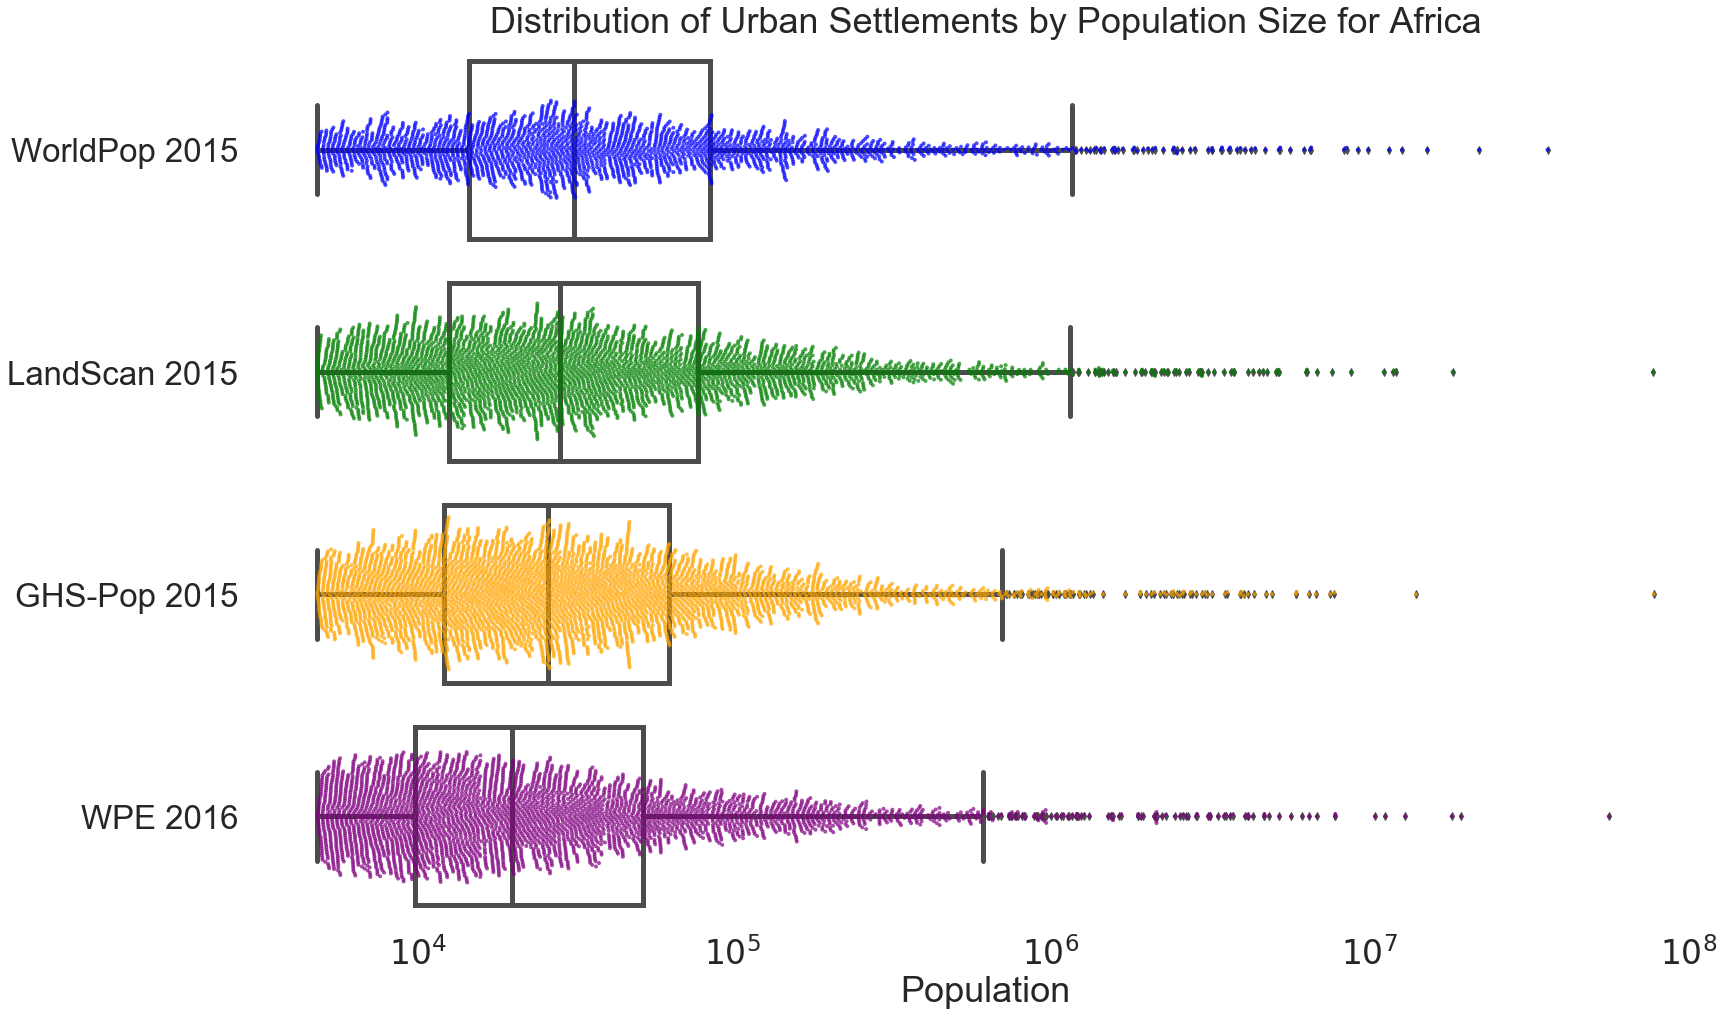

In [105]:
sns.set(font_scale=3)
color = ['Blue', 'Green', 'Orange', 'Purple']
fig = plt.subplots(figsize=[20,30])


ax1 = sns.boxplot(y=df.data, x=np.log10(df.PopTot), linewidth = 5)

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))

ax = sns.swarmplot(y=df.data, x=np.log10(df.PopTot), palette = color, size = 4, alpha = 0.7, orient = 'h')
    
# set size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 15)
#plt.gca().set_xscale('log')

# labels
plt.xlabel('Population')
plt.xticks((4,5,6,7,8), [' $10^4$', '$10^5$', '$10^6$', '$10^7$', '$10^8$'])
plt.ylabel('')
plt.title('Distribution of Urban Settlements by Population Size for Africa')
ax.set_facecolor('White')
plt.tight_layout()

fig.savefig('/Users/cascade/Desktop/'+'PopAll_Swarm.png', dpi=700, transparent=False)

In [134]:
print(np.mean(WP2015.PopTot))
print(np.mean(LS2015.PopTot))
print(np.mean(GHS2015.PopTot))
print(np.mean(WPE2016.PopTot))

192841.175010489
150905.62246777164
120365.36796596061
137187.51139171014


In [123]:
print(np.sum(WP2015_chunks[3]))
print(np.sum(LS2015_chunks[3]))
print(np.sum(GHS2015_chunks[3]))
print(np.sum(WPE2016_chunks[3]))

34533143.84853259
53319903.0
42797144.48549347
35043497.0


In [121]:
print(np.sum(WP2015_chunks[0:7]))
print(np.sum(LS2015_chunks[0:7]))
print(np.sum(GHS2015_chunks[0:7]))
print(np.sum(WPE2016_chunks[0:7]))

464940072.950289
573592271.0
500960661.47432804
499774104.0


In [136]:
(np.sum(GHS2015.PopTot) - np.sum(GHS2000.PopTot)) / np.sum(GHS2000.PopTot) *100

56.348813627516606

In [160]:
big15 = GHS2015.loc[(GHS2015['PopTot'] > 10**6) & (GHS2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
big00 = GHS2000.loc[(GHS2000['PopTot'] > 10**6) & (GHS2000['PopTot'] <= 5*10**6), 'PopTot'].sum()

small15 = GHS2015.loc[(GHS2015['PopTot'] > 10**6) & (GHS2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
small00 = GHS2000.loc[(GHS2000['PopTot'] > 10**6) & (GHS2000['PopTot'] <= 5*10**6), 'PopTot'].sum()


# small15 = np.sum(GHS2015[GHS2015.PopTot < 10**6])

# big00 = np.sum(GHS2000[GHS2000.PopTot >= 10**6])
# small00 = np.sum(GHS2000[GHS2000.PopTot < 10**6])

# print(big15.PopTot - big00.PopTot)
# print(small15.PopTot - small00.PopTot)

In [138]:
print(np.sum(GHS2000.PopTot))
print(np.sum(GHS2015.PopTot))

320412192.36099243
500960661.47432804


In [168]:
GHS2015_5m - GHS2000_5m

41766275.861678764

# Circle Packing 
https://github.com/elmotec/circlify

In [57]:
import circlify as circ

data = [19, 17, 13]
labels = ['a','b', 'b']
circles = circ.circlify(data, with_enclosure=True)

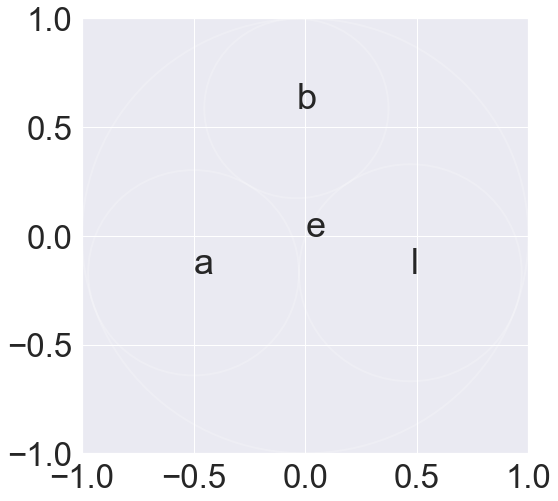

NoneType

In [64]:
ax = circ.bubbles(circles, labels = 'labels').`

## Heat Maps

In [ ]:
np.around(WP2015.groupby('country').PopTot.sum())

In [ ]:
GHS2015[GHS2015'country' = ]

In [ ]:
# create dataset
GHS2000_sort = GHS2000.sort_values(by = 'lat', ascending=False)

In [ ]:
GHS2000_sort

In [ ]:
GHS2000_sort_pop = GHS2000_sort.PopTot.tolist()

In [ ]:
end = list([5000] * 142)

In [ ]:
len(end)

In [ ]:
type(end)

In [ ]:
GHS2000_sort_sq = end+GHS2000_sort_pop
len(GHS2000_sort_sq)

In [ ]:
GHS2000_log = np.log(GHS2000_sort_sq)

In [ ]:
GHS2000_arr = np.reshape(GHS2000_sort_sq,((40,100)))

In [ ]:
GHS2000_arr[1:4,1:4]

In [ ]:
#### color map
sns.heatmap(GHS2000_arr, robust = 500000)


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)
plt.gca().set_xscale('log')
plt.xlabel('Urban Settlement Size')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

#plt.tick_params(axis='', which='major', labelsize=0)
plt.title('GHS2000 HeatMap', x = 0.25)

#fig.savefig('/Users/cascade/Desktop/'+'PopRainGHS2000-15_box.png', dpi=700, transparent=False,
#           bbox_inches='tight')

In [ ]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
 
# Create data
x = GHS2000.PopTot.sort_values(ascending=True)
y = GHS2000.PopTot.sort_values(ascending=True)

#y = np.random.randn(4096)
 
# Create heatmap
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(64,64))
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
 
# Plot heatmap
plt.clf()
plt.title('Pythonspot.com heatmap example')
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap)
plt.show()